# Dynamic time warping: Maldives

### Package import

The _dtadistance_ package is only available via pip. All other packages are available via pip or conda. Install using the requirements.txt or environment.yml (when using conda).

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

In [2]:
sns.set(rc={'figure.figsize':(11.7,5)})

**Available packages**:
- dtaidistance
- FastDTW
- dtw-python

In [29]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

import fastdtw as fastdtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy import stats
from src.savitzky_golay import savitzky_golay

Window function (from here: https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay)

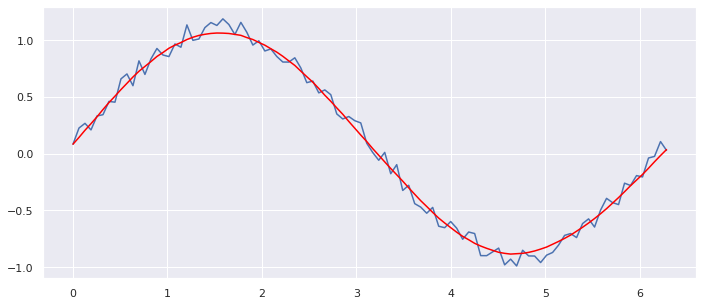

In [25]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.show()

### Data import and processing

#### Target curve: Benthic stack LR04

In [4]:
stack = pd.read_csv('data/LR04stack.txt', sep='\\t', engine='python')
stack = stack[['Time_ka', 'Benthic_d18O_per-mil']]

In [5]:
# stack['benthic_norm'] = zscore(stack['Benthic_d18O_per-mil'])

#### Data curves: M74/4-1100 & M74/4-1150

In [33]:
df_1100 = pd.read_csv('data/1100_complete.csv')
df_1100 = df_1100[['depth_m', 'd18O_pl', 'aragonite']]
df_1100.to_csv('data/core_1100.csv', index=False)

In [34]:
x = df_1100['depth_m']
y = df_1100['d18O_pl']

x = np.array(x)
y = np.array(y)
y = savitzky_golay(y, 11, 3) # window size 51, polynomial order 3

<AxesSubplot:>

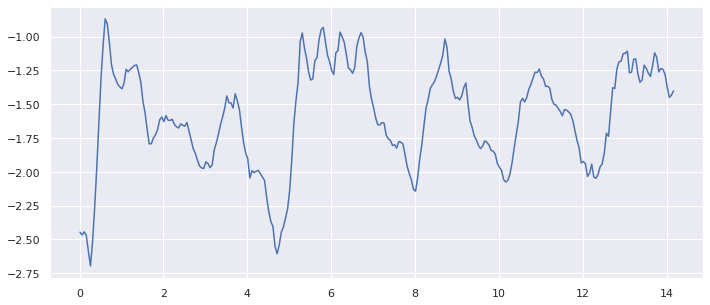

In [35]:
# sns.lineplot(data=df_1100, x='depth_m', y='d18O_pl')
sns.lineplot(x=x, y=y)

In [38]:
df_1150 = pd.read_csv('data/1150_complete.csv')

In [39]:
df_1150 = df_1150[['depth_m', 'd18O_pl', 'aragonite']]

In [40]:
df_1150.to_csv('data/core_1150.csv', index=False)

### PACKAGE: dtaidistance

#### Target (Reference)

Make a sub-selection from the stack 

In [48]:
_tmp = stack[stack['Time_ka'] <= 372]

In [49]:
target = _tmp['Benthic_d18O_per-mil']

In [50]:
target = stats.zscore(target)

In [51]:
target[:5]

0   -2.071828
1   -2.071828
2   -2.182550
3   -1.938962
4   -1.916818
Name: Benthic_d18O_per-mil, dtype: float64

#### Data

In [75]:
df_1100['window'] = df_1100['d18O_pl'].apply(lambda x: savitzky_golay(x, 51, 3)) # window size 51, polynomial order 3


/tmp/ipykernel_743/3743594916.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
/tmp/ipykernel_743/3743594916.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 

TypeError: 'float' object is not subscriptable

In [67]:
# df_1100.head()

,depth_m,d18O_pl,aragonite,mov_avg
0,0.01,-1.924,NaN,NaN
1,0.06,-2.673,NaN,NaN
2,0.11,-2.551,70.05,-7.148
3,0.16,-2.537,69.52,-7.761
4,0.21,-2.290,68.07,-7.378


In [68]:
data = df_1100['mov_avg']

In [69]:
data = stats.zscore(data)

In [70]:
data[:5]

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: mov_avg, dtype: float64

#### MATCHING

In [71]:
path = dtw.warping_path(data, target)
warped = dtw.warp(data, target, path)
fig = dtwvis.plot_warping(data, target, path)

ValueError: need at least one array to concatenate

<Figure size 842.4x360 with 2 Axes>

In [23]:
distance = dtw.distance(data, target)
print(distance)

7.858336784778161


##### LOOP THROUGH STACK INTERVAL

In [24]:
results = []
for i in range(100, 1000, 5):
    target = stack[stack['Time_ka'] <= i]
    target = target['Benthic_d18O_per-mil']
    target = stats.zscore(target)
    distance = dtw.distance(data, target)
    results.append([i, distance])

In [25]:
x = []
y = []
for group in results:
    x.append(group[0])
    y.append(group[1])

In [26]:
data_graph = pd.DataFrame({'x': x, 'y': y})

<AxesSubplot:xlabel='x', ylabel='y'>

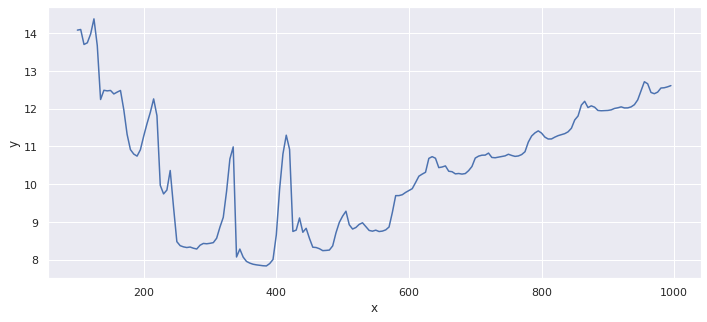

In [27]:
sns.lineplot(data=data_graph, x='x', y='y')

In [28]:
result_metric = pd.DataFrame({'max_age': x, 'distance': y})

In [29]:
selection = result_metric[result_metric['distance'] <= 8]

<AxesSubplot:xlabel='max_age', ylabel='distance'>

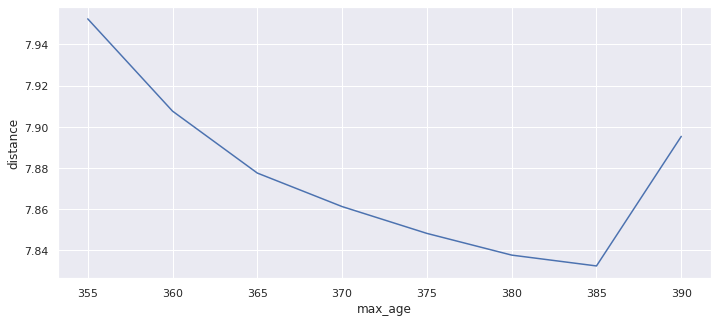

In [30]:
sns.lineplot(data=selection, x=selection['max_age'], y=selection['distance'])

In [31]:
selection['max_age'].describe()

count      8.000000
mean     372.500000
std       12.247449
min      355.000000
25%      363.750000
50%      372.500000
75%      381.250000
max      390.000000
Name: max_age, dtype: float64

In [32]:
df_1100['index'] = df_1100.index

In [33]:
def map_warping_path(index: int):
    """Map the warping path to the original indices"""
    for item in path:
        if item[0] == index:
            return item[1]

In [34]:
df_1100['dtw_age'] = df_1100['index'].apply(lambda x: map_warping_path(x))

<AxesSubplot:xlabel='depth_m', ylabel='dtw_age'>

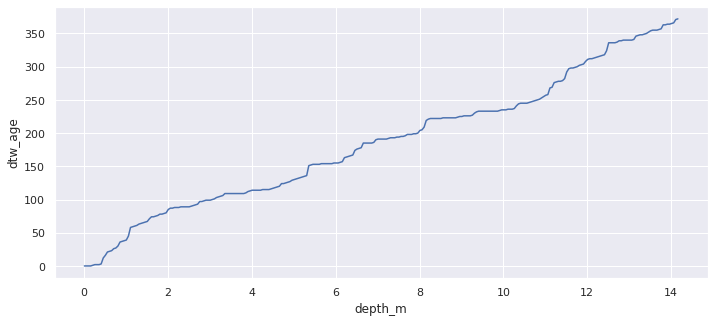

In [35]:
sns.lineplot(data=df_1100, x='depth_m', y='dtw_age')

<AxesSubplot:xlabel='Time_ka', ylabel='Benthic_d18O_per-mil'>

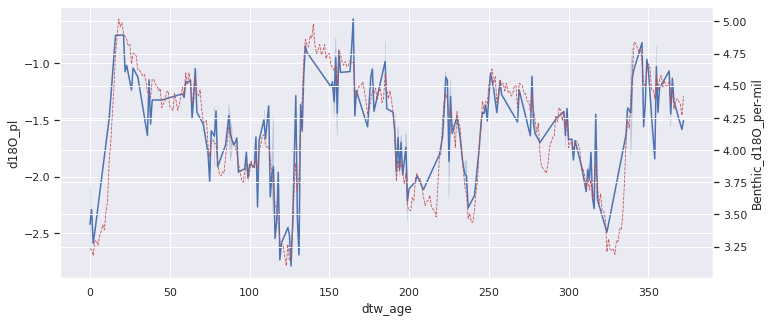

In [36]:
stack = stack[stack['Time_ka'] <= 372]
sns.lineplot(data=df_1100, x='dtw_age', y='d18O_pl')
ax2 = plt.twinx()
sns.set_style("whitegrid", {'axes.grid' : False})
sns.lineplot(data=stack, x='Time_ka', y='Benthic_d18O_per-mil', ax=ax2, color="r", legend=True, linestyle='dashed', linewidth='0.8')

In [37]:
ax1.set_yticks(np.linspace(*ax1.get_ybound(), 10))

NameError: name 'ax1' is not defined

In [ ]:
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path, filename="warp.png")

(None, None)

In [ ]:
warped = dtw.warp(s1, s2, path)

In [ ]:
dtwvis.plot_warp(s1, s2, warped[0], path, filename="warp.png")

(None, None)

In [ ]:
# df = pd.read_csv('data/1100_complete.csv')
df = pd.read_csv('data/1150_complete.csv')

In [ ]:
d18o = df[['depth_m', 'd18O_pl']]
arag = df[['depth_m', 'aragonite']]

In [ ]:
arag = arag.dropna()
d18o = d18o.dropna()

In [ ]:
arag

,depth_m,aragonite
0,0.01,62.06
1,0.06,58.84
2,0.11,56.45
3,0.16,56.35
4,0.21,64.61
...,...,...
285,14.26,48.44
286,14.31,48.43
287,14.36,48.54
288,14.41,50.17


In [ ]:
d18o.to_csv('data.csv', index=False, header=False, sep=" ", decimal=',')

In [ ]:
stack = pd.read_csv('LR04stack.txt', sep='\\t', engine='python')

FileNotFoundError: [Errno 2] No such file or directory: 'LR04stack.txt'

In [ ]:
stack = stack[stack['Time_ka'] < 140]

In [ ]:
stack = stack[['Time_ka', 'Benthic_d18O_per-mil']]

In [ ]:
stack.columns

In [ ]:
stack.to_csv('target.csv', index=False, header=False, sep=" ", decimal=',')

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [ ]:
distance, path = fastdtw(stack, d18o, dist=euclidean)

In [ ]:
from scipy import stats

In [ ]:
target = stack['Benthic_d18O_per-mil']

In [ ]:
data = d18o['d18O_pl']

In [ ]:
# data = arag['aragonite']

In [ ]:
target = stats.zscore(target)

In [ ]:
data = stats.zscore(data)

In [ ]:
data = data * -1

In [ ]:
len(data)

In [ ]:
len(target)

In [ ]:
path = dtw.warping_path(data, target)
warped = dtw.warp(data, target, path)
fig = dtwvis.plot_warping(data, target, path)


In [ ]:
dtwvis.plot_warp(data, target, warped[0], path, filename="warp.svg")

In [ ]:
len(warped[0])

In [ ]:
distance = dtw.distance(data, target)
print(distance)

In [ ]:
data = stats.zscore(data)
results = []
stack = pd.read_csv('LR04stack.txt', sep='\\t', engine='python')
for i in range(100, 1000, 5):
    target = stack[stack['Time_ka'] <= i]
    target = target['Benthic_d18O_per-mil']
    target = stats.zscore(target)
    distance = dtw.distance(data, target)
    results.append([i, distance])

In [ ]:
for group in results:
    print(group)

In [ ]:
import numpy as np

## A noisy sine wave as query
idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/10.0

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)

## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(query, template, keep_internals=True, window_type='sakoechiba', window_args={'window_size': 100})

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")
print(alignment.normalizedDistance)
alignment.index1

# Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
# dtw(query, template, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c")).plot(type="threeway",offset=-2)

## See the recursion relation, as formula and diagram
# print(rabinerJuangStepPattern(6,"c"))
# rabinerJuangStepPattern(6,"c").plot()

## And much more!

In [ ]:
alignment.index2